Universidad del Valle de Guatemala

Data Science

Fernanda Esquivel 21542

Sofi Lam 21548

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
consumo = pd.read_csv('CONSUMO.csv')
importacion=pd.read_csv('IMPORTACION.csv')
PreciosPromedio=pd.read_csv('PreciosPromedio.csv')

#Consumo

In [4]:
consumo["Gasolina superior"] = consumo["Gasolina superior"].astype(str)
consumo["Gasolina superior"] = consumo["Gasolina superior"].apply(lambda x: x.replace(',', '')).astype(float)
consumo.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Kerosina,Mezclas\noleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
0,Jan-00,0,"48,446.00","296,766.99",0.0,0,0,0,"194,410.48","1,426.00",...,"64,026.09",0,0.0,0,0,0,0.0,"634,667.06",0,"1,750,544.64"
1,Feb-00,0,"50,597.00","328,116.44",0.0,0,0,0,"174,710.55","1,458.00",...,"62,660.30",0,0.0,0,0,0,0.0,"642,380.66",0,"1,773,220.22"
2,Mar-00,0,"27,593.00","368,589.63",0.0,0,0,0,"189,234.07","1,503.00",...,"61,361.99",0,0.0,0,0,0,0.0,"699,807.25",0,"1,909,498.79"
3,Apr-00,0,"53,794.00","396,300.47",0.0,0,0,0,"174,330.61","1,561.00",...,"61,814.32",0,0.0,0,0,0,0.0,"586,803.98",0,"1,800,932.86"
4,May-00,0,"60,137.00","449,368.92",0.0,0,0,0,"191,745.15","1,642.00",...,"54,098.32",0,0.0,0,0,0,0.0,"656,948.20",0,"1,941,771.90"


Pasamos la columna de fecha al formato de fecha para podeer realizar las series de tiempo correspondientes.

In [5]:
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'],format='%b-%y', errors='coerce')

In [6]:
consumo.set_index('Fecha', inplace=True)

**Serie de tiempo consumo**

In [7]:
consumo_superior_resampled = consumo['Gasolina superior'].resample('M').mean()

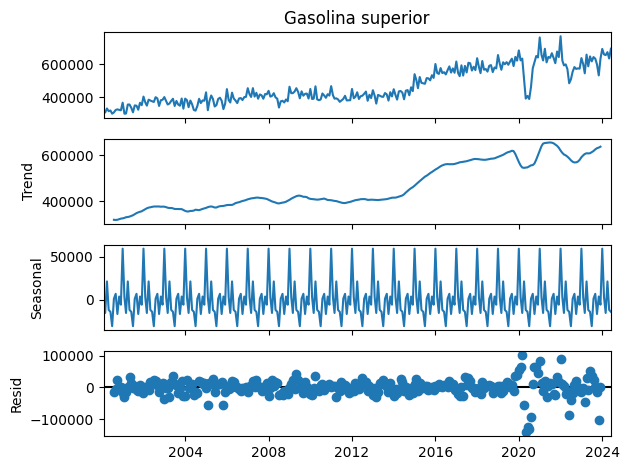

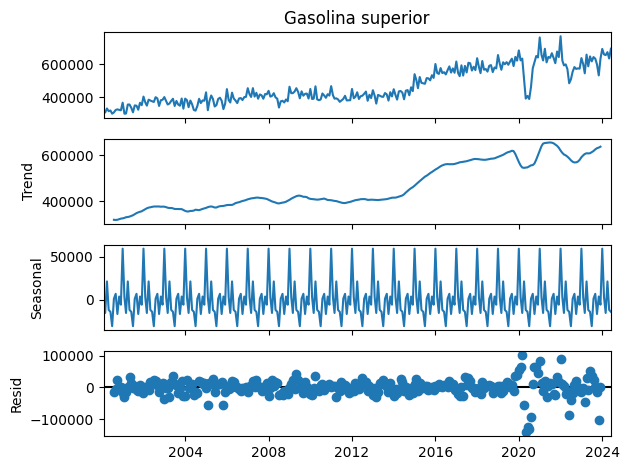

In [8]:
resultado_superiorC = seasonal_decompose(consumo_superior_resampled.dropna())
resultado_superiorC.plot()

**LSTM**

In [9]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumo_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.678783
p-value                        0.852169
# de retardos usados          12.000000
# de observaciones usadas    280.000000
Critical Value (1%)           -3.453922
Critical Value (5%)           -2.871918
Critical Value (10%)          -2.572300
dtype: float64


In [10]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
consumo_diff = consumo_superior_resampled.diff()
consumo_diff.fillna(0,inplace=True)
dfTest = adfuller(consumo_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.675884
p-value                        0.000093
# de retardos usados          16.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


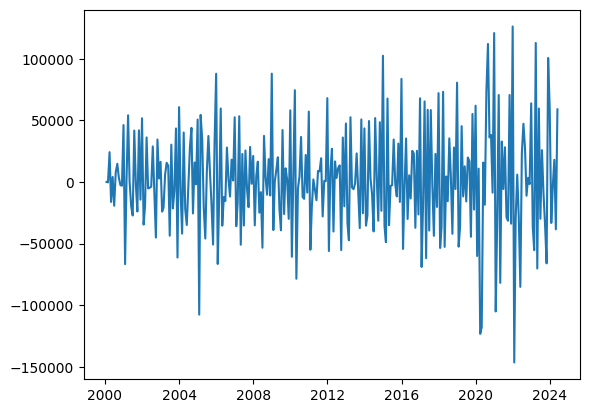

In [11]:
plt.plot(consumo_diff)

In [12]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
consumo_diff_array = consumo_diff.values

# Reshape a 2D
consumo_diff_array = consumo_diff_array.reshape(-1, 1)
data_c = scaler.fit_transform(consumo_diff_array)

In [13]:
entrenamiento = round(0.6*len(data_c))
val_prueba = round(0.2*len(data_c))
test = data_c[(entrenamiento+val_prueba)-1:]
validation = data_c[(entrenamiento):entrenamiento+val_prueba+1]
train = data_c[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [14]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

xC_train,yC_train = supervisada(train)
xC_val,yC_val = supervisada(validation)
xC_test,yC_test = supervisada(test)


In [15]:
xC_train = np.reshape(xC_train,(xC_train.shape[0],1,1))
xC_val = np.reshape(xC_val, (xC_val.shape[0],1,1))
xC_test = np.reshape(xC_test, (xC_test.shape[0],1,1))
len(xC_val)

59

In [16]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(unidades, input_shape=(lote, caracteristicas), stateful=False))
modelo1.add(Dense(1))
modelo1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [18]:
epocas = 50
history= modelo1.fit(
    x = xC_train,
    y = yC_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xC_val,yC_val),
    verbose=1
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5644 - val_loss: 1.0460
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5577 - val_loss: 1.0326
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5526 - val_loss: 1.0222
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5487 - val_loss: 1.0143
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5457 - val_loss: 1.0085
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5435 - val_loss: 1.0046
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5420 - val_loss: 1.0022
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5411 - val_loss: 1.0009
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5407 - val_loss: 0.9999
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5402 - val_loss: 0.9985
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5396 - val_loss: 0.9964
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

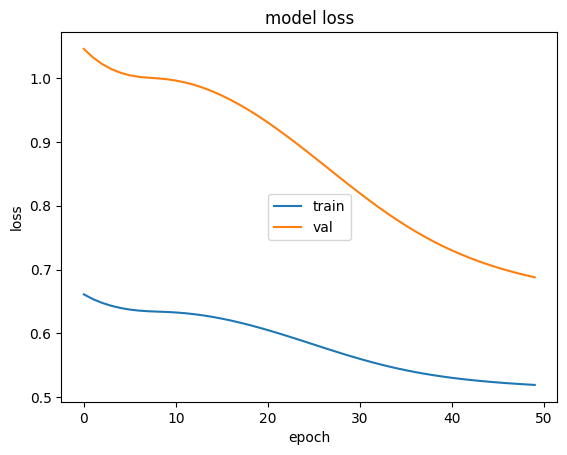

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [20]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = xC_train,
    y = yC_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = xC_val,
    y = yC_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = xC_test,
    y = yC_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4910  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6997 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0422 


1.907226324081421

In [21]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccionC_val = prediccion_fun(xC_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo_superior_resampled.values , n=entrenamiento)
prediccionC_test = prediccion_fun(xC_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo_superior_resampled.values , n=entrenamiento+val_prueba)

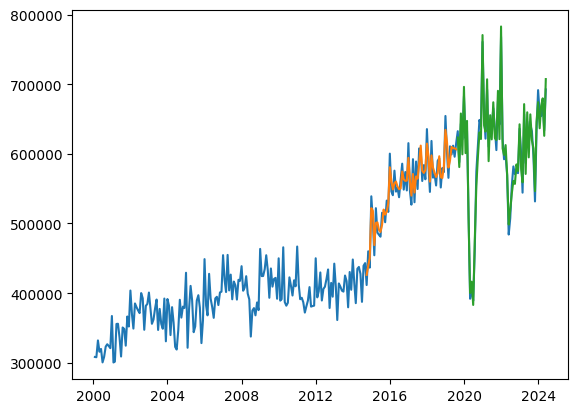

In [22]:
df_val = pd.DataFrame(prediccionC_val,index=consumo_superior_resampled[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccionC_test,index=consumo_superior_resampled[entrenamiento+len(df_val):len(consumo_superior_resampled)].index)


plt.plot(consumo_superior_resampled)
plt.plot(df_val)
plt.plot(df_test)



# Importacion


In [23]:
importacion["Gasolina superior"] = importacion["Gasolina superior"].astype(str)
importacion["Gasolina superior"] = importacion["Gasolina superior"].apply(lambda x: x.replace(',', '')).astype(float)
importacion.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
0,1-Jan,0,"27,748.99","214,581.84",0.0,0,0,0,"194,065.74",820,...,0.0,0,0,0,0.0,"566,101.99","8,402.00",0,"715,344.00","2,312,639.05"
1,1-Feb,0,"7,503.57","294,609.00",0.0,0,0,0,"170,703.38","3,054.00",...,0.0,0,0,0,0.0,"489,525.80",0,0,"370,166.00","1,769,208.76"
2,1-Mar,0,"26,304.32","315,263.80",0.0,0,0,0,"161,837.37",677,...,0.0,0,0,0,0.0,"575,559.68",0,0,"360,530.00","1,945,770.26"
3,1-Apr,0,"7,885.89","205,653.00",0.0,0,0,0,"163,048.64","3,399.00",...,0.0,0,0,0,0.0,"437,745.42","8,184.00",0,"359,527.00","1,623,637.76"
4,1-May,0,"8,443.16","278,371.30",0.0,0,0,0,"171,518.86",585,...,0.0,0,0,0,0.0,"552,609.13","12,680.00",0,"723,346.00","2,262,726.64"


In [24]:
importacion['Fecha'] = pd.to_datetime(importacion['Fecha'], format='%d-%b', errors='coerce')
importacion.set_index('Fecha', inplace=True)

**Series de tiempo**

In [25]:
importacion_superior_resampled = importacion['Gasolina superior'].resample('M').mean()

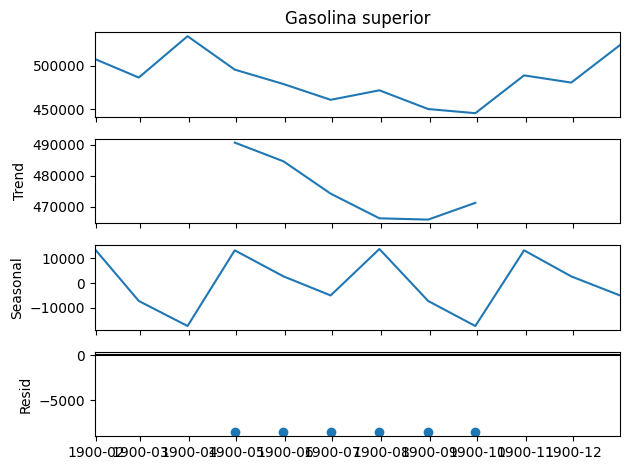

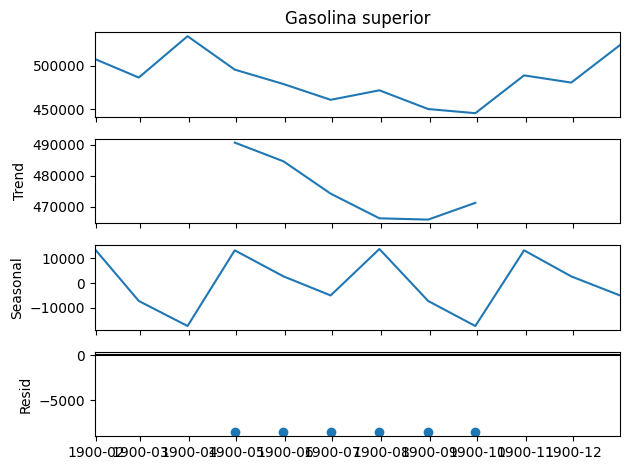

In [26]:
resultado_superior_i = seasonal_decompose(importacion_superior_resampled.dropna(), period=6)
resultado_superior_i.plot()

**LSTM**

In [27]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(importacion_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -1.851236
p-value                       0.355337
# de retardos usados          0.000000
# de observaciones usadas    11.000000
Critical Value (1%)          -4.223238
Critical Value (5%)          -3.189369
Critical Value (10%)         -2.729839
dtype: float64


In [28]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
importacion_diff = importacion_superior_resampled.diff()
importacion_diff.fillna(0,inplace=True)
dfTest = adfuller(importacion_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -4.125597
p-value                       0.000878
# de retardos usados          0.000000
# de observaciones usadas    11.000000
Critical Value (1%)          -4.223238
Critical Value (5%)          -3.189369
Critical Value (10%)         -2.729839
dtype: float64


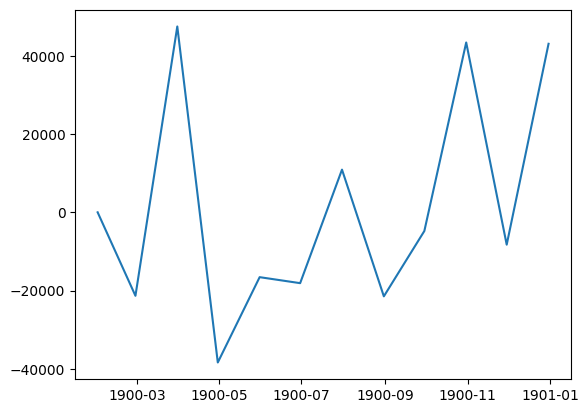

In [29]:
plt.plot(importacion_diff)

In [30]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
importacion_diff_array = importacion_diff.values

# Reshape a 2D
importacion_diff_array = importacion_diff_array.reshape(-1, 1)
data_i = scaler.fit_transform(importacion_diff_array)

In [31]:
entrenamiento_i = round(0.6*len(data_i))
val_prueba_i = round(0.2*len(data_i))
test = data_i[(entrenamiento_i+val_prueba_i)-1:]
validation = data_i[(entrenamiento_i):entrenamiento_i+val_prueba_i+1]
train = data_i[0:entrenamiento_i]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

4

In [32]:
xi_train,yi_train = supervisada(train)
xi_val,yi_val = supervisada(validation)
xi_test,yi_test = supervisada(test)


In [33]:
xi_train = np.reshape(xi_train,(xi_train.shape[0],1,1))
xi_val = np.reshape(xi_val, (xi_val.shape[0],1,1))
xi_test = np.reshape(xi_test, (xi_test.shape[0],1,1))
len(xi_val)

2

In [34]:
epocas = 50
history_i= modelo1.fit(
    x = xi_train,
    y = yi_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xi_val,yi_val),
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6991 - val_loss: 1.0296
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6965 - val_loss: 1.0331
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6941 - val_loss: 1.0365
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6918 - val_loss: 1.0399
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6896 - val_loss: 1.0433
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6874 - val_loss: 1.0467
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6853 - val_loss: 1.0501
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6832 - val_loss: 1.0535
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6812 - val_loss: 1.0568
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6792 - val_loss: 1.0602
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6773 - val_loss: 1.0635
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6754 - val_loss: 1.0669
Ep

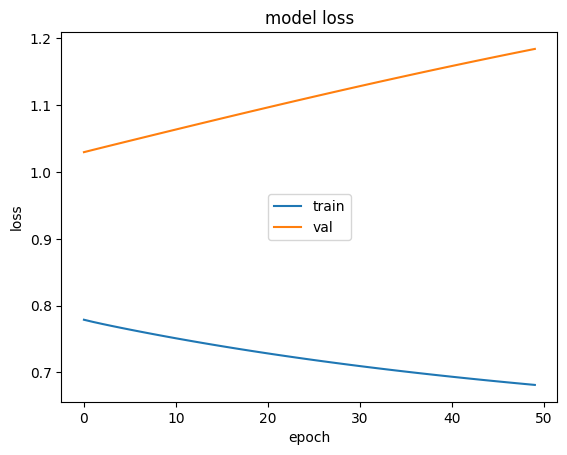

In [35]:
plt.plot(history_i.history['loss'])
plt.plot(history_i.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [36]:
prediccioni_val = []

prediccioni_val = prediccion_fun(xi_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series =importacion_superior_resampled.values , n=entrenamiento_i)
prediccioni_test = prediccion_fun(xi_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importacion_superior_resampled.values , n=entrenamiento_i+val_prueba_i)

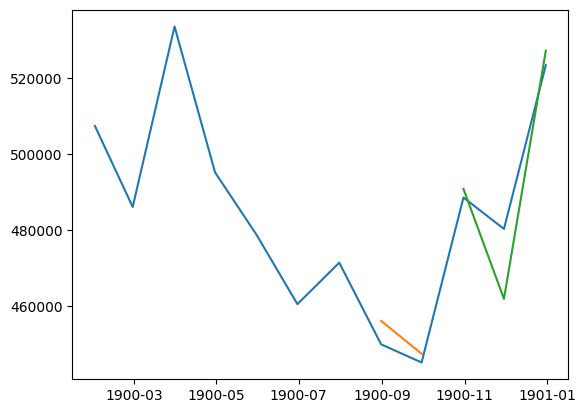

In [37]:
df_val_i = pd.DataFrame(prediccioni_val, index=importacion_superior_resampled[(entrenamiento_i):entrenamiento_i+val_prueba_i].index)
df_test_i = pd.DataFrame(prediccioni_test, index=importacion_superior_resampled[entrenamiento_i+len(df_val_i):len(importacion_superior_resampled)].index)


plt.plot(importacion_superior_resampled)
plt.plot(df_val_i)
plt.plot(df_test_i)


# Precios

In [38]:
PreciosPromedio.head()

,FECHA,Tipo de cambio,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,1-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
1,2-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
2,3-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
3,4-Jan-21,7.79417,21.91,21.11,17.61,13.45,99.0,3.96
4,5-Jan-21,7.79369,21.91,21.11,17.61,13.45,99.0,3.96


In [39]:
#PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], format='%d-%b-%Y', errors='coerce')
PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], errors='coerce')

<ipython-input-39-e3779208609a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], errors='coerce')


In [40]:
PreciosPromedio.set_index('FECHA', inplace=True)

**Serie de tiempo**

In [41]:
precio_superior_resampled = PreciosPromedio['Superior'].resample('M').mean()

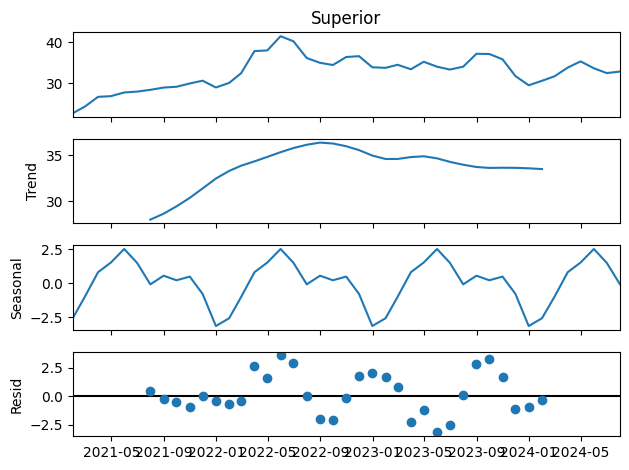

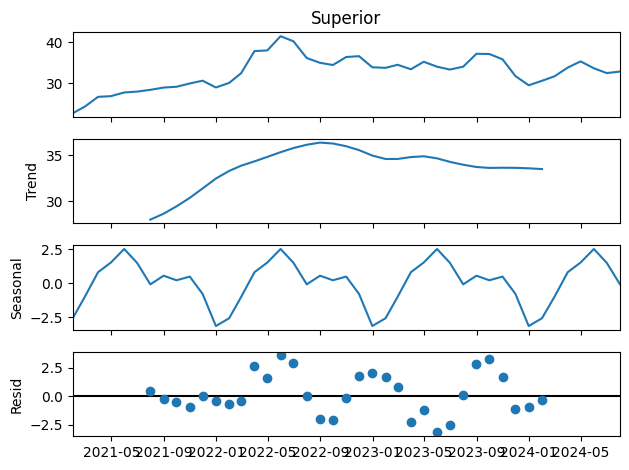

In [42]:
resultado_superiorP = seasonal_decompose(precio_superior_resampled.dropna())
resultado_superiorP.plot()


In [43]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(precio_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -2.777253
p-value                       0.061597
# de retardos usados          1.000000
# de observaciones usadas    41.000000
Critical Value (1%)          -3.600983
Critical Value (5%)          -2.935135
Critical Value (10%)         -2.605963
dtype: float64


In [44]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
precio_diff = precio_superior_resampled.diff()
precio_diff.fillna(0,inplace=True)
dfTest = adfuller(precio_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -4.843615
p-value                       0.000045
# de retardos usados          0.000000
# de observaciones usadas    42.000000
Critical Value (1%)          -3.596636
Critical Value (5%)          -2.933297
Critical Value (10%)         -2.604991
dtype: float64


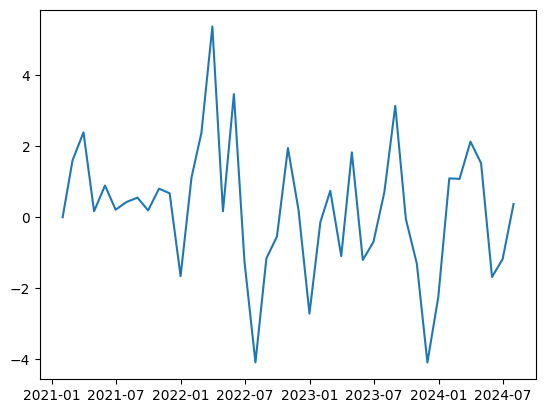

In [45]:
plt.plot(precio_diff)

In [46]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
precio_diff_array = precio_diff.values

# Reshape a 2D
precio_diff_array = precio_diff_array.reshape(-1, 1)
data_p = scaler.fit_transform(precio_diff_array)

In [47]:
entrenamiento_p = round(0.6*len(data_p))
val_prueba_p = round(0.2*len(data_p))
test = data_p[(entrenamiento_p+val_prueba_p)-1:]
validation = data_p[(entrenamiento_p):entrenamiento_p+val_prueba_p+1]
train = data_p[0:entrenamiento_p]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

9

In [48]:
xp_train,yp_train = supervisada(train)
xp_val,yp_val = supervisada(validation)
xp_test,yp_test = supervisada(test)

In [49]:
xp_train = np.reshape(xp_train,(xp_train.shape[0],1,1))
xp_val = np.reshape(xp_val, (xp_val.shape[0],1,1))
xp_test = np.reshape(xp_test, (xp_test.shape[0],1,1))
len(xp_val)

9

In [50]:
epocas = 50
history_p= modelo1.fit(
    x = xp_train,
    y = yp_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xp_val,yp_val),
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0113 - val_loss: 1.5513
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9933 - val_loss: 1.5490
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9783 - val_loss: 1.5469
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9641 - val_loss: 1.5449
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9505 - val_loss: 1.5431
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9375 - val_loss: 1.5414
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9251 - val_loss: 1.5399
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9133 - val_loss: 1.5385
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9021 - val_loss: 1.5371
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8913 - val_loss: 1.5359
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8810 - val_loss: 1.5348
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8712 - val_lo

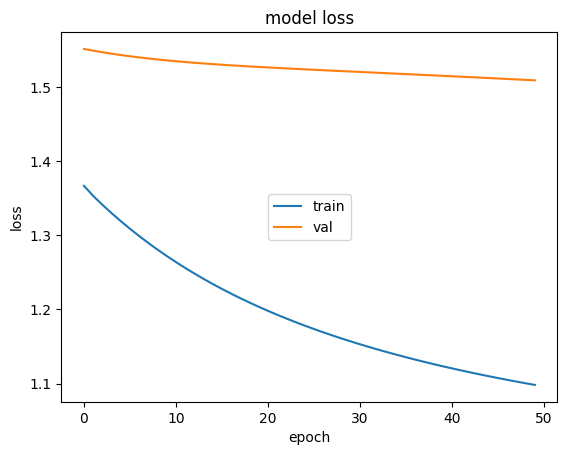

In [51]:
plt.plot(history_p.history['loss'])
plt.plot(history_p.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [52]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = xp_train,
    y = yp_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = xp_val,
    y = yp_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = xp_test,
    y = yp_test
)

Pérdida en Entrenamiento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0953
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5090
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7782


0.7781577110290527

In [53]:
prediccionp_val = []

prediccionp_val = prediccion_fun(xp_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series =precio_superior_resampled.values , n=entrenamiento_p)
prediccionp_test = prediccion_fun(xp_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = precio_superior_resampled.values , n=entrenamiento_p+val_prueba_p)

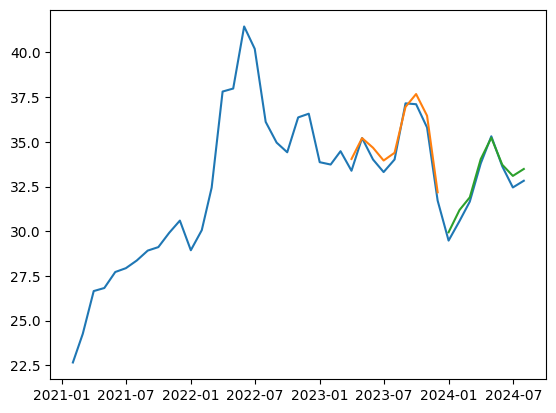

In [54]:
df_val_p = pd.DataFrame(prediccionp_val,index=precio_superior_resampled[(entrenamiento_p):entrenamiento_p+val_prueba_p].index)
df_test_p = pd.DataFrame(prediccionp_test,index=precio_superior_resampled[entrenamiento_p+len(df_val_p):len(precio_superior_resampled)].index)


plt.plot(precio_superior_resampled)
plt.plot(df_val_p)
plt.plot(df_test_p)
